In [16]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel, NaiveSeasonal, NaiveDrift, ExponentialSmoothing
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality
from darts.metrics import mape
from darts.datasets import AirPassengersDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode

# Pandas settings
pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [17]:
data_ins = pd.read_csv('data_inside.csv')
data_outs = pd.read_csv('data_outside.csv')

# combine inside and outside data and interpolate based on time of inside
data = pd.merge(data_ins, data_outs, on='time', how='outer')
# Converting the index to DatetimeIndex
data.index = pd.to_datetime(data['time'])
data_interp = data.interpolate(method='time')
# Get Out NaNs
data_interp = data_interp.dropna()

In [18]:
data_interp

,time,temperature_x,humidity_x,pressure_x,current,voltage,temperature_y,humidity_y,pressure_y,Live_Irms,Irms
time,,,,,,,,,,,
2023-04-30 16:26:53.745120,2023-04-30 16:26:53.745120,4.85,33.60,"101,956.85","65,401.45","18,501.12",19.78,41.55,"101,982.02",7.15,6.33
2023-04-30 16:27:04.636999,2023-04-30 16:27:04.636999,4.85,33.60,"101,956.85","65,401.45","18,501.12",19.78,41.54,"101,982.50",7.13,6.27
2023-04-30 16:27:15.524893,2023-04-30 16:27:15.524893,4.85,33.60,"101,956.85","65,401.45","18,501.12",19.77,41.54,"101,981.83",7.12,6.36
2023-04-30 16:27:26.408301,2023-04-30 16:27:26.408301,4.85,33.60,"101,956.85","65,401.45","18,501.12",19.78,41.55,"101,981.83",7.12,6.37
2023-04-30 16:27:37.290567,2023-04-30 16:27:37.290567,4.84,33.45,"101,956.66","65,401.45","18,501.12",19.78,41.55,"101,981.64",6.15,5.27
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-05 12:29:07.932481,2023-05-05 12:29:07.932481,5.02,38.66,"101,447.94","65,401.45","18,501.12",19.17,51.86,"101,474.26",7.23,6.47
2023-05-05 12:29:19.104497,2023-05-05 12:29:19.104497,5.01,38.34,"101,447.97","65,401.45","18,501.12",19.18,51.86,"101,473.30",7.23,6.68
2023-05-05 12:29:30.269770,2023-05-05 12:29:30.269770,4.99,38.01,"101,448.00","65,401.45","18,501.12",19.18,51.85,"101,472.35",7.20,6.54


In [19]:
# create a TimeSeries object from the dataframe
# resample the data to a 10-second frequency
df_resampled = data_interp.resample('60S').mean()
# Drop NaN values by interpolating
df_resampled = data_interp.interpolate(method='time')
df_resampled = data_interp.resample('60S').mean()
# Drop NaN values
df_resampled = df_resampled.dropna()
# print the TimeSeries object
# print(series)
df_resampled['temperature_x']

time
2023-04-30 16:26:00   4.85
2023-04-30 16:27:00   4.84
2023-04-30 16:28:00   4.75
2023-04-30 16:29:00   4.65
2023-04-30 16:30:00   4.54
                      ... 
2023-05-05 12:25:00   5.26
2023-05-05 12:26:00   5.21
2023-05-05 12:27:00   5.15
2023-05-05 12:28:00   5.08
2023-05-05 12:29:00   5.00
Freq: 60S, Name: temperature_x, Length: 6964, dtype: float64

In [20]:
ts_df = TimeSeries.from_dataframe(df_resampled, freq='60S')
ts_df

<TimeSeries (DataArray) (time: 6964, component: 10, sample: 1)>
array([[[     4.85],
        [    33.6 ],
        [101956.85],
        ...,
        [101982.02],
        [     7.15],
        [     6.33]],

       [[     4.84],
        [    33.4 ],
        [101956.59],
        ...,
        [101981.9 ],
        [     5.61],
        [     4.91]],

       [[     4.75],
        [    32.11],
        [101955.4 ],
        ...,
...
        ...,
        [101474.14],
        [     7.27],
        [     6.63]],

       [[     5.08],
        [    40.01],
        [101448.14],
        ...,
        [101473.82],
        [     7.24],
        [     6.52]],

       [[     5.  ],
        [    38.2 ],
        [101447.99],
        ...,
        [101472.72],
        [     5.88],
        [     5.31]]])
Coordinates:
  * time       (time) datetime64[ns] 2023-04-30T16:26:00 ... 2023-05-05T12:29:00
  * component  (component) object 'temperature_x' 'humidity_x' ... 'Irms'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [21]:
from darts.utils.missing_values import fill_missing_values

ts_df = fill_missing_values(ts_df, "auto")
ts_df

<TimeSeries (DataArray) (time: 6964, component: 10, sample: 1)>
array([[[     4.85],
        [    33.6 ],
        [101956.85],
        ...,
        [101982.02],
        [     7.15],
        [     6.33]],

       [[     4.84],
        [    33.4 ],
        [101956.59],
        ...,
        [101981.9 ],
        [     5.61],
        [     4.91]],

       [[     4.75],
        [    32.11],
        [101955.4 ],
        ...,
...
        ...,
        [101474.14],
        [     7.27],
        [     6.63]],

       [[     5.08],
        [    40.01],
        [101448.14],
        ...,
        [101473.82],
        [     7.24],
        [     6.52]],

       [[     5.  ],
        [    38.2 ],
        [101447.99],
        ...,
        [101472.72],
        [     5.88],
        [     5.31]]])
Coordinates:
  * time       (time) datetime64[ns] 2023-04-30T16:26:00 ... 2023-05-05T12:29:00
  * component  (component) object 'temperature_x' 'humidity_x' ... 'Irms'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

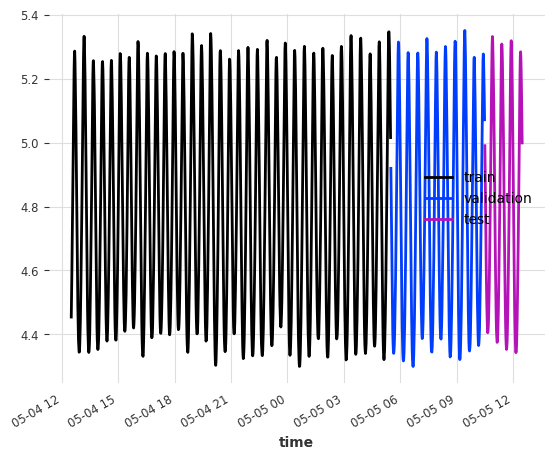

In [22]:
delete, ts = ts_df.split_after(pd.Timestamp("2023-05-04 12:29:00"))
ts_train, ts_test = ts.split_after(pd.Timestamp("2023-05-05 05:29:00"))
ts_val, ts_test = ts_test.split_after(pd.Timestamp("2023-05-05 10:29:00"))
ts_train['temperature_x'].plot(label='train')
ts_val['temperature_x'].plot(label='validation')
ts_test['temperature_x'].plot(label='test')

In [8]:
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)

In [9]:
model_air = NBEATSModel(
    input_chunk_length=180 * 6, output_chunk_length=90 * 6, n_epochs=200, random_state=0
)

In [10]:
model_air.fit(ts_train, verbose=True);

Training: 0it [00:00, ?it/s]